# 1. Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


from gensim.models import Word2Vec


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2026-02-08 19:33:21.719017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770579201.900432      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770579201.956350      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770579202.413007      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770579202.413063      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770579202.413065      24 computation_placer.cc:177] computation placer alr

# 2. Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/pricerunner/pricerunner_aggregate.csv")
df.head()

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


# 3. Basic Preprocessing

In [3]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df.columns)


Index(['product_id', 'product_title', 'merchant_id', 'cluster_id',
       'cluster_label', 'category_id', 'category_label'],
      dtype='object')


# 4. Train-Test Split

In [4]:
texts = df["product_title"].astype(str).values
labels = df["category_label"].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

num_classes = len(np.unique(y))

X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


# 5. Dataset Exploration

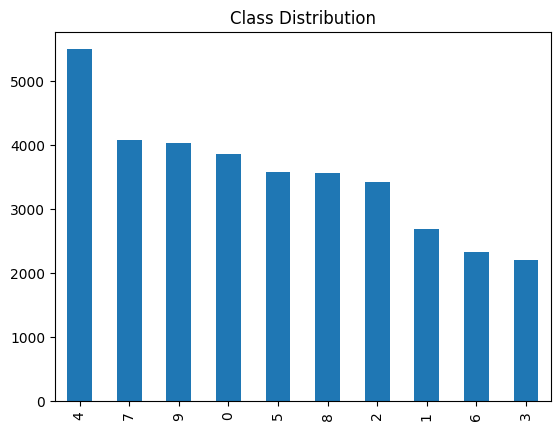

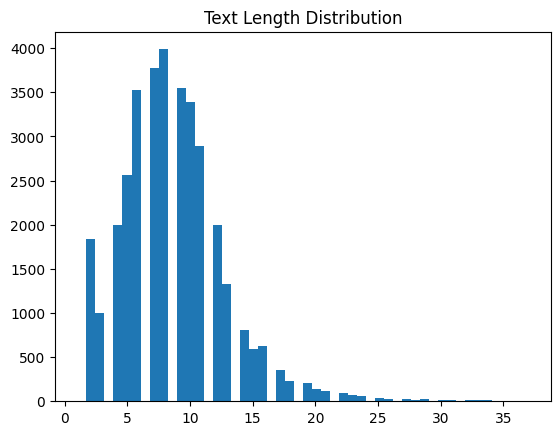

In [5]:
plt.figure()
pd.Series(y).value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.show()


text_lengths = [len(t.split()) for t in texts]
plt.figure()
plt.hist(text_lengths, bins=50)
plt.title("Text Length Distribution")
plt.show()

In [6]:
import pickle

best_model = None
best_tokenizer = None
best_embedding_name = None
best_f1 = 0.0


# 6. GRU with TF-IDF

In [7]:
print("\n--- GRU with TF-IDF ---")


max_features = 10000


tfidf = TfidfVectorizer(max_features=max_features)
X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf.transform(X_test_text).toarray()


# Expand dims for GRU (timesteps=1)
X_train_tfidf = np.expand_dims(X_train_tfidf, axis=1)
X_test_tfidf = np.expand_dims(X_test_tfidf, axis=1)


model_tfidf = Sequential([
GRU(128, input_shape=(1, max_features)),
Dropout(0.5),
Dense(num_classes, activation='softmax')
])


model_tfidf.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)


model_tfidf.fit(
X_train_tfidf,
y_train_cat,
validation_split=0.1,
epochs=10,
batch_size=64
)

pred_tfidf = np.argmax(model_tfidf.predict(X_test_tfidf), axis=1)
print(classification_report(y_test, pred_tfidf))



--- GRU with TF-IDF ---


I0000 00:00:1770579238.521536      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770579238.527418      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


I0000 00:00:1770579244.901905      69 cuda_dnn.cc:529] Loaded cuDNN version 91002


398/398 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7178 - loss: 1.5293 - val_accuracy: 0.9448 - val_loss: 0.2707
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9634 - loss: 0.2114 - val_accuracy: 0.9692 - val_loss: 0.1501
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9818 - loss: 0.1064 - val_accuracy: 0.9773 - val_loss: 0.1161
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9884 - loss: 0.0683 - val_accuracy: 0.9802 - val_loss: 0.1009
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9898 - loss: 0.0483 - val_accuracy: 0.9816 - val_loss: 0.0924
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9912 - loss: 0.0378 - val_accuracy: 0.9805 - val_loss: 0.0895
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9916 - loss: 0.0323 - val_accuracy: 0.9805 - val_loss: 0.0862
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9916 - loss: 0.0279 - val_accuracy: 0.9819 - val_

# 7. Tokenization for Word2Vec

In [8]:
max_words = 20000
max_len = 20


tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)


X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)


X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


word_index = tokenizer.word_index
vocab_size = min(max_words, len(word_index) + 1)

# 8. Word2Vec Training (Skip-gram & CBOW)

In [9]:
train_tokens = [text.split() for text in X_train_text]


w2v_skip = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    workers=4,
    seed=SEED
)


w2v_cbow = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    sg=0,
    workers=4,
    seed=SEED
)


def build_embedding_matrix(w2v_model):
    embedding_matrix = np.zeros((vocab_size, 100))
    for word, idx in word_index.items():
        if idx < vocab_size and word in w2v_model.wv:
            embedding_matrix[idx] = w2v_model.wv[word]
    return embedding_matrix


embedding_skip = build_embedding_matrix(w2v_skip)
embedding_cbow = build_embedding_matrix(w2v_cbow)

# 9. GRU Model Builder

In [10]:
def build_gru_model(embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=100,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False
        ),
        GRU(128),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 10. GRU + Skip-gram

In [11]:
print("\n--- GRU with Word2Vec Skip-gram ---")
model_skip = build_gru_model(embedding_skip)
model_skip.fit(
    X_train_pad,
    y_train_cat,
    validation_split=0.1,
    epochs=10,
    batch_size=64
)


pred_skip = np.argmax(model_skip.predict(X_test_pad), axis=1)
print(classification_report(y_test, pred_skip))


--- GRU with Word2Vec Skip-gram ---
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5001 - loss: 1.3096 - val_accuracy: 0.9112 - val_loss: 0.3248
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9233 - loss: 0.2352 - val_accuracy: 0.9313 - val_loss: 0.1820
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9389 - loss: 0.1827 - val_accuracy: 0.9419 - val_loss: 0.1655
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9448 - loss: 0.1584 - val_accuracy: 0.9434 - val_loss: 0.1576
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9484 - loss: 0.1461 - val_accuracy: 0.9458 - val_loss: 0.1479
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9530 - loss: 0.1329 - val_accuracy: 0.9458 - val_loss: 0.1421
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9554 - loss: 0.1262 - val_accuracy: 0.9522 - val_loss: 0.1375
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9555 - loss: 0.1243 - val_accuracy: 0.9547 - val_

# 11. GRU + CBOW

In [12]:
print("\n--- GRU with Word2Vec CBOW ---")
model_cbow = build_gru_model(embedding_cbow)
model_cbow.fit(
    X_train_pad,
    y_train_cat,
    validation_split=0.1,
    epochs=10,
    batch_size=64
)


pred_cbow = np.argmax(model_cbow.predict(X_test_pad), axis=1)
print(classification_report(y_test, pred_cbow))


--- GRU with Word2Vec CBOW ---
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5648 - loss: 1.1810 - val_accuracy: 0.8991 - val_loss: 0.2761
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9145 - loss: 0.2562 - val_accuracy: 0.9253 - val_loss: 0.2226
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9264 - loss: 0.2161 - val_accuracy: 0.9264 - val_loss: 0.2034
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9313 - loss: 0.1979 - val_accuracy: 0.9335 - val_loss: 0.1932
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9360 - loss: 0.1866 - val_accuracy: 0.9349 - val_loss: 0.1845
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9395 - loss: 0.1760 - val_accuracy: 0.9345 - val_loss: 0.1822
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9410 - loss: 0.1658 - val_accuracy: 0.9345 - val_loss: 0.1708
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9443 - loss: 0.1588 - val_accuracy: 0.9405 - val_

# 12. Summary Table

In [13]:
results = pd.DataFrame({
    'Model': ['GRU'],
    'TF-IDF': [accuracy_score(y_test, pred_tfidf)],
    'Skip-gram': [accuracy_score(y_test, pred_skip)],
    'CBOW': [accuracy_score(y_test, pred_cbow)]
})


print(results)

  Model    TF-IDF  Skip-gram    CBOW
0   GRU  0.972108    0.95441  0.9445


In [14]:
best_embedding = results.drop(columns=["Model"]).idxmax(axis=1).values[0]
best_score = results.drop(columns=["Model"]).max(axis=1).values[0]

print(f"Best model: GRU + {best_embedding} (Accuracy = {best_score:.4f})")


Best model: GRU + TF-IDF (Accuracy = 0.9721)


# 13. Confusion Matrices for all Embeddings

In [15]:
def plot_confusion_matrix(model, X_test, y_test, title):
    # Predict
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()


221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


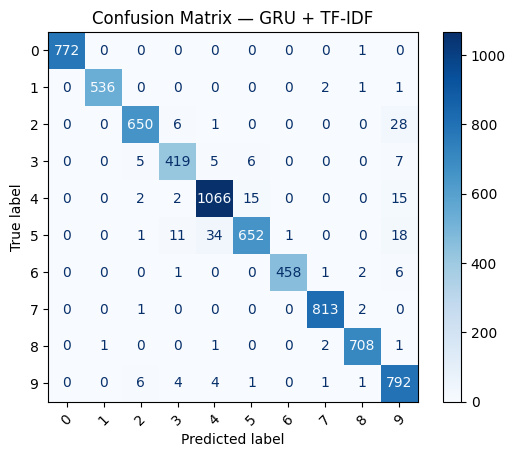

In [16]:
plot_confusion_matrix(
    model=model_tfidf,
    X_test=X_test_tfidf,
    y_test=y_test,
    title="Confusion Matrix — GRU + TF-IDF"
)


221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


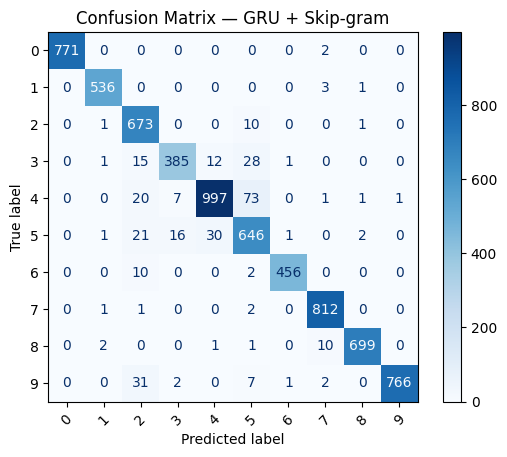

In [17]:
plot_confusion_matrix(
    model=model_skip,
    X_test=X_test_pad,
    y_test=y_test,
    title="Confusion Matrix — GRU + Skip-gram"
)


221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


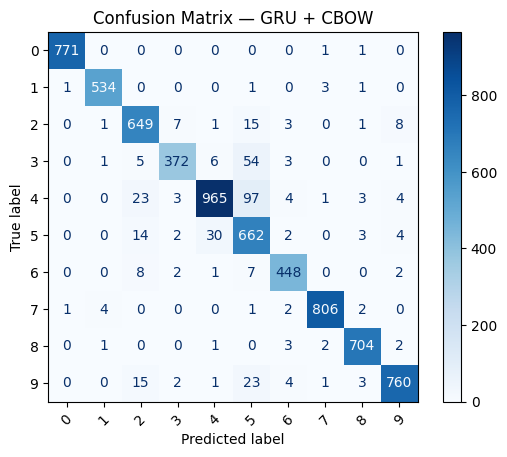

In [18]:
plot_confusion_matrix(
    model=model_cbow,
    X_test=X_test_pad,
    y_test=y_test,
    title="Confusion Matrix — GRU + CBOW"
)
